<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/working_copy_not_ready_yet_Crime_Hotspot_Prediction_LSTM_Area_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
#Import dataset:

crime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crime_clean.csv')
print(crime_df.shape)

(2883802, 26)


In [ ]:
crime_df.columns

Index(['DR_NO', 'Date_Rptd', 'DATE_OCC', 'TIME_OCC', 'AREA', 'AREA_NAME',
       'Rpt_Dist_No', 'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age',
       'Vict_Sex', 'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp',
       'Avg_Dewpoint', 'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure',
       'Total_Precipitation', 'Weapon_Reported', 'Crime_Category',
       'Crime_Category_Code', 'Region_Ethnic_Origin'],
      dtype='object')

In [ ]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [ ]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])

In [ ]:
crime_df.set_index('DATE_OCC', inplace=True)


In [ ]:
# Convert the following into categorical

crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [ ]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [ ]:
print(crime_df.columns)

Index(['DR_NO', 'Date_Rptd', 'TIME_OCC', 'AREA', 'AREA_NAME', 'Rpt_Dist_No',
       'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age', 'Vict_Sex',
       'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp', 'Avg_Dewpoint',
       'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure', 'Total_Precipitation',
       'Weapon_Reported', 'Crime_Category', 'Crime_Category_Code',
       'Region_Ethnic_Origin', 'Crime_Incidence'],
      dtype='object')


In [ ]:
crime_df.dtypes

DR_NO                      int64
Date_Rptd                 object
TIME_OCC                   int64
AREA                       int64
AREA_NAME               category
Rpt_Dist_No                int64
Part_1-2                   int64
Crm_Cd                     int64
Crm_Cd_Desc               object
Vict_Age                 float64
Vict_Sex                  object
Vict_Descent              object
LOCATION                  object
LAT                      float64
LON                      float64
Avg_Temp                 float64
Avg_Dewpoint             float64
Avg_Humidity             float64
Avg_Windspeed            float64
Avg_Pressure             float64
Total_Precipitation      float64
Weapon_Reported            int64
Crime_Category            object
Crime_Category_Code        int64
Region_Ethnic_Origin      object
Crime_Incidence            int64
dtype: object

In [ ]:
# area_mapping = {
#    'Central': 'Central_Bureau', 'Hollenbeck': 'Central_Bureau', 'Newton': 'Central_Bureau', 'Northeast': 'Central_Bureau', 'Rampart': 'Central_Bureau',
#    '77th Street': 'South_Bureau', 'Harbor': 'South_Bureau', 'Southeast': 'South_Bureau', 'Southwest': 'South_Bureau',
#    'Hollywood': 'West_Bureau', 'Olympic': 'West_Bureau', 'Pacific': 'West_Bureau', 'West Los Angeles': 'West_Bureau', 'Wilshire': 'West_Bureau',
#    'Devonshire': 'Valley_Bureau', 'Foothill': 'Valley_Bureau', 'Mission': 'Valley_Bureau', 'N Hollywood': 'Valley_Bureau', 'Topanga': 'Valley_Bureau', 'Van Nuys': 'Valley_Bureau', 'West Valley': 'Valley_Bureau',
#}
# Creating the new variable, BUREAU.

# crime_df['BUREAU'] = crime_df['AREA_NAME'].map(area_mapping)

In [ ]:
crime_df.head(5)

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,48.0,...,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican,38
2010-02-20,100100638,02/20/2010 12:00:00 AM,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0.0,...,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other,16
2010-02-20,100100639,02/20/2010 12:00:00 AM,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,25.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16
2010-02-20,100106650,02/20/2010 12:00:00 AM,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,53.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,16
2010-02-20,100106654,02/20/2010 12:00:00 AM,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,18.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,16


In [ ]:
crime_df.shape

(2883802, 26)

In [ ]:
# Convert the following into categorical

# crime_df['BUREAU'] = crime_df['BUREAU'].astype('category')

In [ ]:
crime_df['AREA_NAME'].value_counts()

77th Street    186392
Southwest      184073
Central        156659
Pacific        150005
N Hollywood    147519
Southeast      145151
Hollywood      142079
Northeast      139159
Van Nuys       137837
Newton         133213
Mission        132084
Rampart        130369
Wilshire       129314
West LA        127442
West Valley    126732
Olympic        126603
Topanga        125854
Devonshire     125420
Harbor         124890
Hollenbeck     110319
Foothill       102688
Name: AREA_NAME, dtype: int64

<Figure size 1200x600 with 0 Axes>

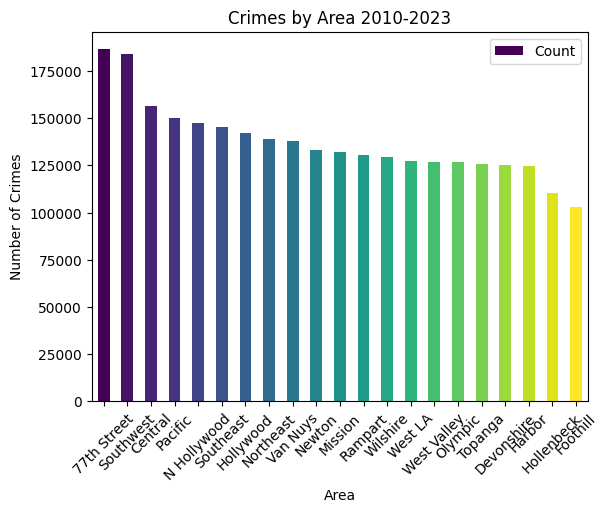

In [ ]:
# Group by AREA and count the number of crimes
crimes_by_area = crime_df.groupby('AREA_NAME')['DR_NO'].count().reset_index(name='Count')


# Sort by crime count
crimes_by_area = crimes_by_area.sort_values('Count', ascending=False)

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(crimes_by_area)))

# Create a bar chart
plt.figure(figsize=(12, 6))
crimes_by_area.plot(kind='bar', x='AREA_NAME', y='Count', color=colors)

# Add labels and title
plt.title('Crimes by Area 2010-2023')
plt.xlabel('Area')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()


In [ ]:
# To split crime_df into four separate datasets based on bureau category.

split_datasets = {}

categories = crime_df['AREA_NAME'].unique()
for category in categories:
  split_datasets[category] = crime_df[crime_df['AREA_NAME'] ==category]

SeventhStreet_dataset = split_datasets['77th Street']
Southwest_dataset = split_datasets['Southwest']
Central_dataset = split_datasets['Central']
Pacific_dataset = split_datasets['Pacific']
N_Hollywood_dataset = split_datasets['N Hollywood']
Southeast_dataset = split_datasets['Southeast']
Hollywood_dataset = split_datasets['Hollywood']
Northeast_dataset = split_datasets['Northeast']
Van_Nuys_dataset = split_datasets['Van Nuys']
Newton_dataset = split_datasets['Newton']
Mission_dataset = split_datasets['Mission']
Rampart_dataset = split_datasets['Rampart']
Wilshire_dataset = split_datasets['Wilshire']
West_LA_dataset = split_datasets['West LA']
West_Valley_dataset = split_datasets['West Valley']
Olympic_dataset = split_datasets['Olympic']
Topanga_dataset = split_datasets['Topanga']
Devonshire_dataset = split_datasets['Devonshire']
Harbor_dataset = split_datasets['Harbor']
Hollenbeck_dataset = split_datasets['Hollenbeck']
Foothill_dataset = split_datasets['Foothill']

In [ ]:
SeventhStreet_dataset.head()

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,101207980,02/22/2010 12:00:00 AM,800,12,77th Street,1232,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Other,74
2010-02-20,101207910,02/20/2010 12:00:00 AM,2030,12,77th Street,1269,2,946,OTHER MISCELLANEOUS CRIME,0.0,...,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Other,74
2010-02-20,101208127,02/24/2010 12:00:00 AM,1915,12,77th Street,1269,1,440,THEFT PLAIN - PETTY ($950 & UNDER),56.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,74
2010-02-20,101207941,02/22/2010 12:00:00 AM,2300,12,77th Street,1205,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,30.0,...,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,74
2010-02-20,101207892,02/21/2010 12:00:00 AM,1300,12,77th Street,1243,1,510,VEHICLE - STOLEN,0.0,...,47.5,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,74


In [ ]:
SeventhStreet_dataset.index.dtype


dtype('<M8[ns]')

**Using Neural Network's LSTM in TensorFlow to Predict Crime Incidence (Hotspot)**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import mean_squared_error
import math
from math import floor,ceil,sqrt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.optimizers import Adam

**22. LSTM for Full Data (All Bureaus)**

In [ ]:
def lstm_prediction(crime_df):
    shape=crime_df.shape[0]
    df_new=crime_df[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('---------------------------------------------------------------------------------------')
    print('-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('---------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    optimizer = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC',size=10)
    plt.ylabel('Amount of Crime Incidences',size=6)
    plt.xticks(crime_df.index, va='vertical_alignment')
    plt.title('L.A. CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()

---------------------------------------------------------------------------------------
-----------L.A. CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
---------------------------------------------------------------------------------------
Shape of Training Set (2307042, 1)
Shape of Validation Set (576760, 1)


Epoch 1/50
57676/57676 - 448s - loss: 0.0013 - val_loss: 6.6733e-04 - 448s/epoch - 8ms/step
Epoch 2/50
57676/57676 - 439s - loss: 0.0012 - val_loss: 6.6827e-04 - 439s/epoch - 8ms/step
Epoch 3/50
57676/57676 - 473s - loss: 0.0012 - val_loss: 6.6237e-04 - 473s/epoch - 8ms/step
Epoch 4/50
57676/57676 - 438s - loss: 0.0012 - val_loss: 6.5898e-04 - 438s/epoch - 8ms/step
Epoch 5/50
57676/57676 - 440s - loss: 0.0012 - val_loss: 6.6260e-04 - 440s/epoch - 8ms/step
Epoch 6/50
57676/57676 - 437s - loss: 0.0012 - val_loss: 6.6816e-04 - 437s/epoch - 8ms/step
Epoch 7/50
57676/57676 - 430s - loss: 0.0012 - val_loss: 6.7476e-04 - 430s/epoch - 7ms/step
Epoch 8/50
57676/57676 - 469s - loss: 0.0012 - val_loss: 6.5334e-04 - 469s/epoch - 8ms/step
Epoch 9/50
57676/57676 - 428s - loss: 0.0012 - val_loss: 6.5443e-04 - 428s/epoch - 7ms/step
Epoch 10/50
57676/57676 - 427s - loss: 0.0012 - val_loss: 6.4947e-04 - 427s/epoch - 7ms/step
Epoch 11/50
57676/57676 - 424s - loss: 0.0012 - val_loss: 6.5311e-04 - 424s/epo

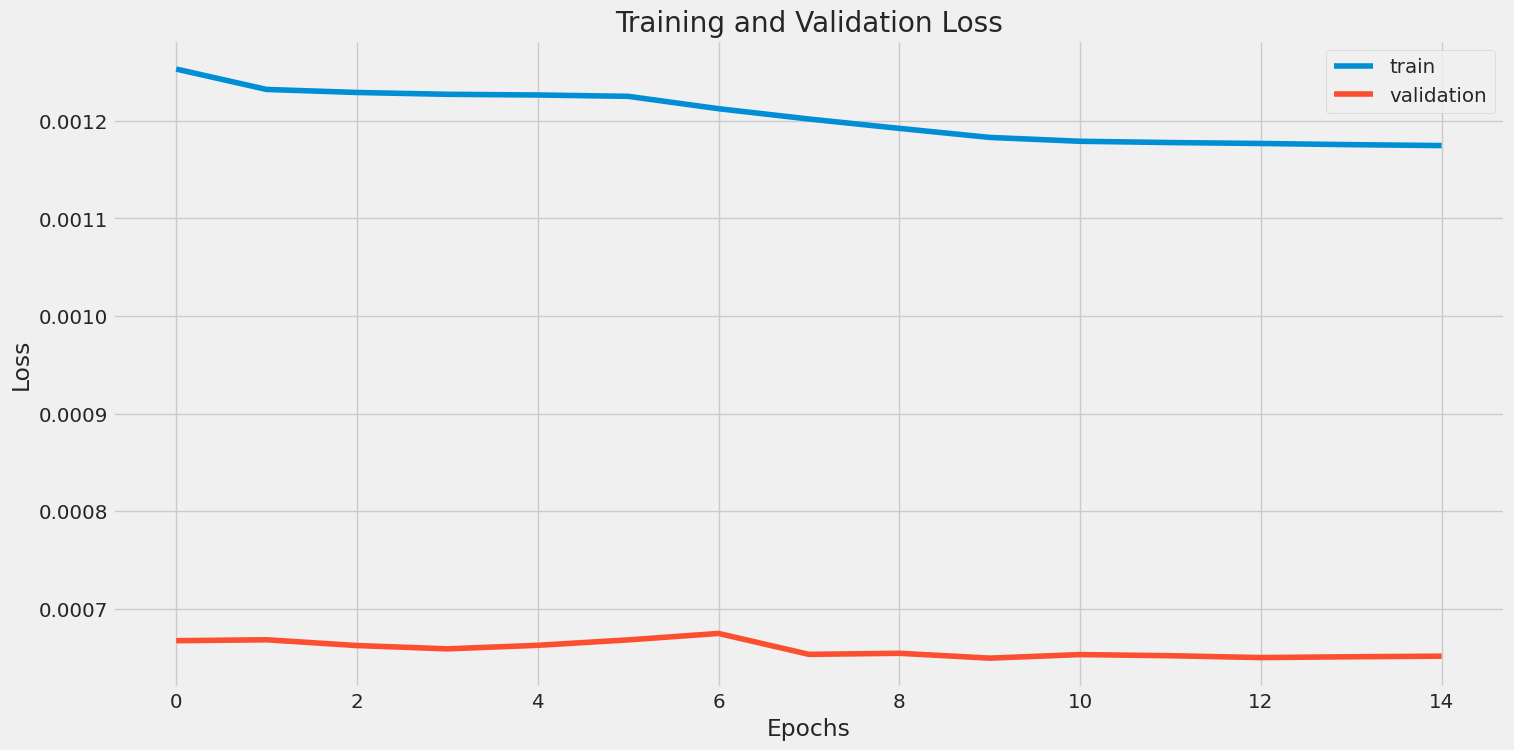

18024/18024 [==============================] - 60s 3ms/step
RMSE value on validation set: Crime_Incidence    16.353411
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


In [ ]:
lstm_prediction(crime_df)

**1. LSTM for 77th Street Area**

In [ ]:
def lstm_prediction(SeventhStreet_dataset):
    shape=SeventhStreet_dataset.shape[0]
    df_new=SeventhStreet_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('--------------------------------------------------------------------------------------------------')
    print('-----------77TH STREET AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.xticks(SeventhStreet_dataset.index, rotation=45)
    plt.title('77TH STREET AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()




--------------------------------------------------------------------------------------------------
-----------77TH STREET AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
--------------------------------------------------------------------------------------------------
Shape of Training Set (149114, 1)
Shape of Validation Set (37278, 1)
Epoch 1/25
3727/3727 - 33s - loss: 2.0315e-04 - val_loss: 7.8961e-05 - 33s/epoch - 9ms/step
Epoch 2/25
3727/3727 - 28s - loss: 1.2761e-04 - val_loss: 6.6684e-05 - 28s/epoch - 8ms/step
Epoch 3/25
3727/3727 - 28s - loss: 1.2399e-04 - val_loss: 6.3541e-05 - 28s/epoch - 8ms/step
Epoch 4/25
3727/3727 - 28s - loss: 1.2007e-04 - val_loss: 5.1941e-05 - 28s/epoch - 7ms/step
Epoch 5/25
3727/3727 - 28s - loss: 1.1973e-04 - val_loss: 5.1685e-05 - 28s/epoch - 7ms/step
Epoch 6/25
3727/3727 - 27s - loss: 1.1852e-04 - val_loss: 5.1636e-05 - 27s/epoch - 7ms/step
Epoch 7/25
3727/3727 - 27s - loss: 1.1809e-04 - val_loss: 5.6507e-05 - 27s/epoch -

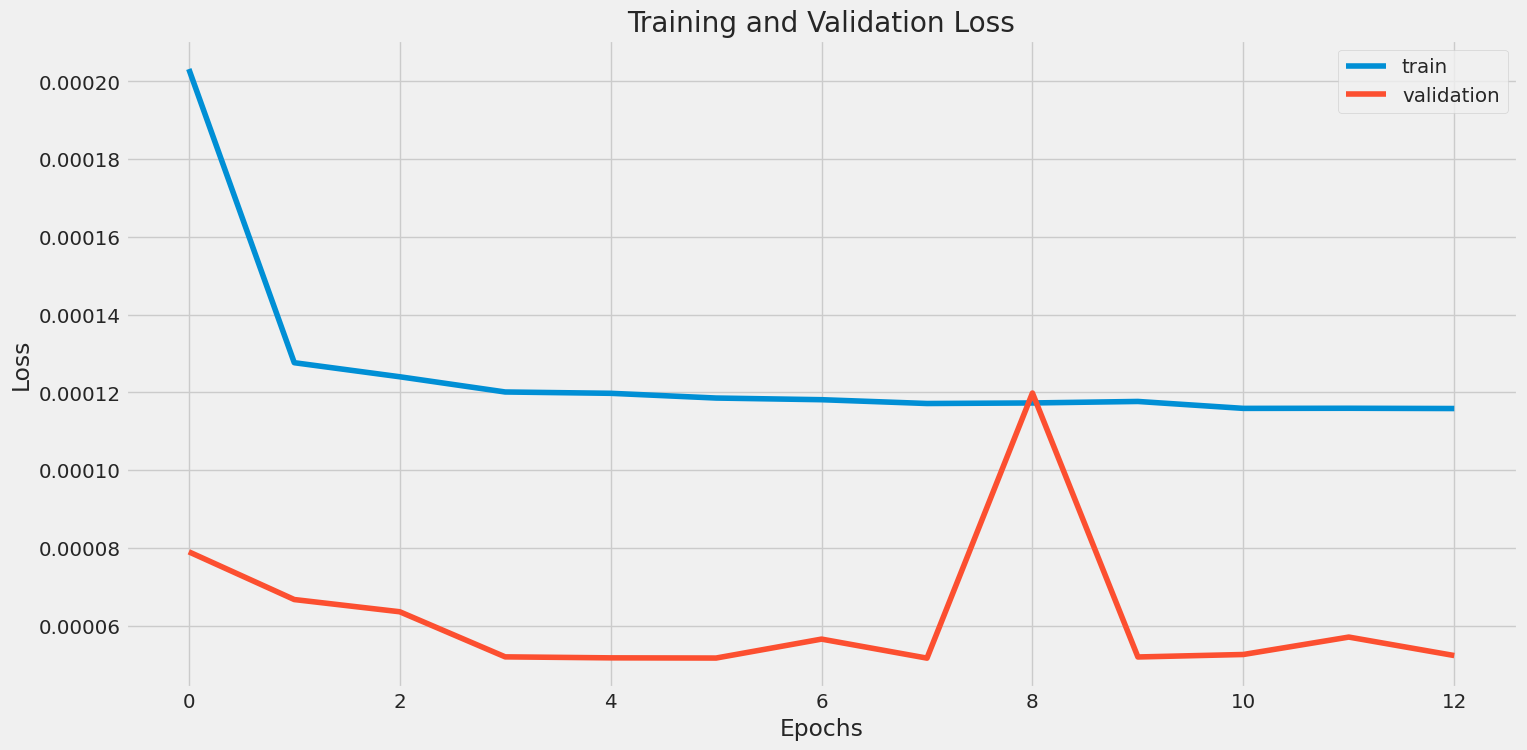

1165/1165 [==============================] - 5s 3ms/step
RMSE value on validation set: Crime_Incidence    3.209554
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


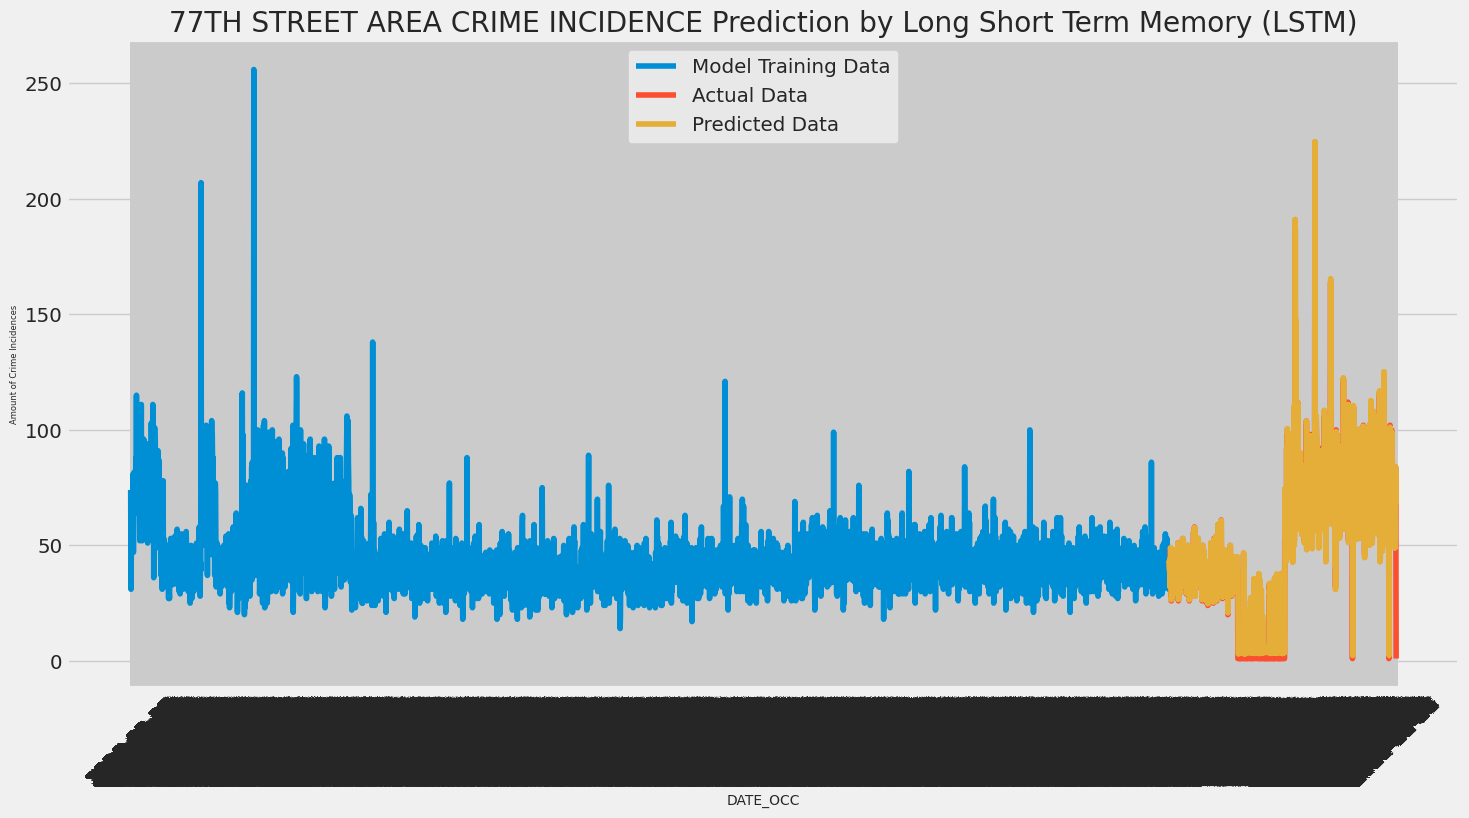

In [ ]:
lstm_prediction(SeventhStreet_dataset)

**2. LSTM for Southwest Area**

In [ ]:
def lstm_prediction(Southwest_dataset):
    shape=Southwest_dataset.shape[0]
    df_new=Southwest_dataset[['Crime_Incidence']]
    dataset = df_new.values
    train=df_new[:ceil(shape*0.80)]
    valid=df_new[ceil(shape*0.80):]

    print('--------------------------------------------------------------------------------------------------')
    print('-----------SOUTHWEST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions
    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.ylabel('Amount of Crime Incidences')
    plt.title('SOUTHWEST AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------SOUTHWEST AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (147259, 1)
Shape of Validation Set (36814, 1)
Epoch 1/25
3681/3681 - 32s - loss: 2.6425e-04 - val_loss: 1.1005e-04 - 32s/epoch - 9ms/step
Epoch 2/25
3681/3681 - 28s - loss: 1.7939e-04 - val_loss: 1.1040e-04 - 28s/epoch - 7ms/step
Epoch 3/25
3681/3681 - 28s - loss: 1.7312e-04 - val_loss: 1.2609e-04 - 28s/epoch - 8ms/step
Epoch 4/25
3681/3681 - 27s - loss: 1.7082e-04 - val_loss: 1.1362e-04 - 27s/epoch - 7ms/step
Epoch 5/25
3681/3681 - 27s - loss: 1.6828e-04 - val_loss: 1.1480e-04 - 27s/epoch - 7ms/step
Epoch 6/25
3681/3681 - 28s - loss: 1.6861e-04 - val_loss: 1.2440e-04 - 28s/epoch - 8ms/step


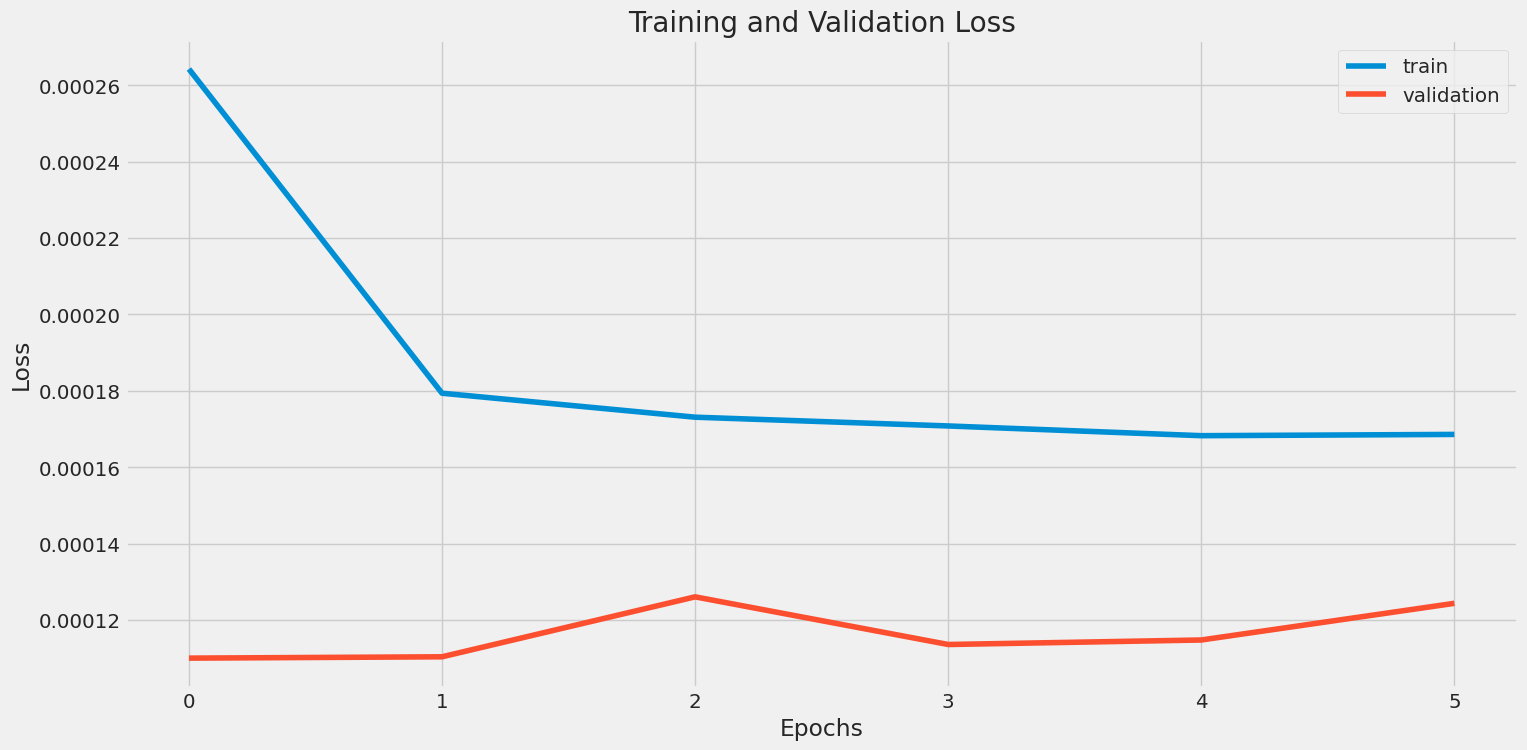

1151/1151 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    2.325415
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


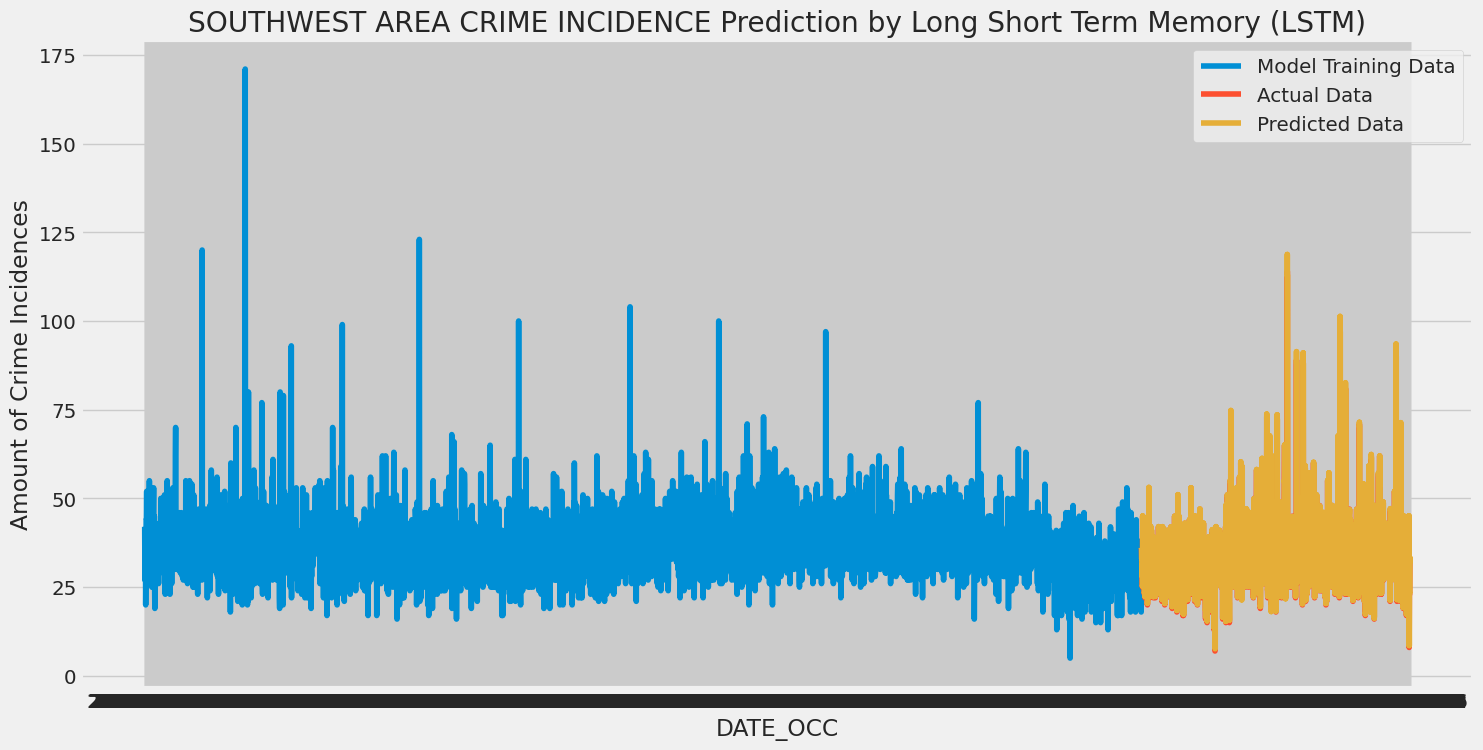

In [ ]:
lstm_prediction(Southwest_dataset)

**3. LSTM for Central Area**

In [ ]:
print(Central_dataset.columns)

Index(['DR_NO', 'Date_Rptd', 'TIME_OCC', 'AREA', 'AREA_NAME', 'Rpt_Dist_No',
       'Part_1-2', 'Crm_Cd', 'Crm_Cd_Desc', 'Vict_Age', 'Vict_Sex',
       'Vict_Descent', 'LOCATION', 'LAT', 'LON', 'Avg_Temp', 'Avg_Dewpoint',
       'Avg_Humidity', 'Avg_Windspeed', 'Avg_Pressure', 'Total_Precipitation',
       'Weapon_Reported', 'Crime_Category', 'Crime_Category_Code',
       'Region_Ethnic_Origin', 'Crime_Incidence'],
      dtype='object')


In [ ]:
def lstm_prediction(Central_dataset, window_size=40, lstm_units=[256, 128], epochs=25, batch_size=32):
    shape = Central_dataset.shape[0]
    df_new = Central_dataset[['Crime_Incidence']].sort_values(by='DATE_OCC')  # Ensure data is sorted by date
    dataset = df_new.values
    train = df_new.iloc[:ceil(shape * 0.80)]
    valid = df_new.iloc[ceil(shape * 0.80):]

    print('--------------------------------------------------------------------------------------------------')
    print('-----------CENTRAL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------')
    print('--------------------------------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=128))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=2, validation_split=0.2, callbacks=[early_stopping])

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    crime_predictions = model.predict(X_test)
    crime_predictions = scaler.inverse_transform(crime_predictions)

    rms=np.sqrt(np.mean(np.power((valid-crime_predictions),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = crime_predictions.reshape(-1)  # Ensure predictions have the right shape


    plt.plot(train['Crime_Incidence'])
    plt.plot(valid[['Crime_Incidence','Predictions']])
    plt.xlabel('DATE_OCC')
    plt.xticks(Central_dataset.index, Central_dataset.index.year, rotation=45)  # Use index instead of 'DATE_OCC'
    plt.ylabel('Amount of Crime Incidences')
    plt.title('CENTRAL AREA CRIME INCIDENCE Prediction by Long Short Term Memory (LSTM)')
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    plt.show()


--------------------------------------------------------------------------------------------------
-----------CENTRAL AREA CRIME INCIDENCE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)---------------
--------------------------------------------------------------------------------------------------
Shape of Training Set (125328, 1)
Shape of Validation Set (31331, 1)
Epoch 1/25
3133/3133 - 28s - loss: 1.8643e-04 - val_loss: 2.8982e-04 - 28s/epoch - 9ms/step
Epoch 2/25
3133/3133 - 23s - loss: 1.0952e-04 - val_loss: 1.9776e-04 - 23s/epoch - 7ms/step
Epoch 3/25
3133/3133 - 23s - loss: 1.0782e-04 - val_loss: 1.2824e-04 - 23s/epoch - 7ms/step
Epoch 4/25
3133/3133 - 23s - loss: 1.0571e-04 - val_loss: 1.4036e-04 - 23s/epoch - 7ms/step
Epoch 5/25
3133/3133 - 24s - loss: 1.0465e-04 - val_loss: 1.2826e-04 - 24s/epoch - 8ms/step
Epoch 6/25
3133/3133 - 24s - loss: 1.0410e-04 - val_loss: 1.3571e-04 - 24s/epoch - 8ms/step
Epoch 7/25
3133/3133 - 23s - loss: 1.0349e-04 - val_loss: 1.4877e-04 - 23s/epoch -

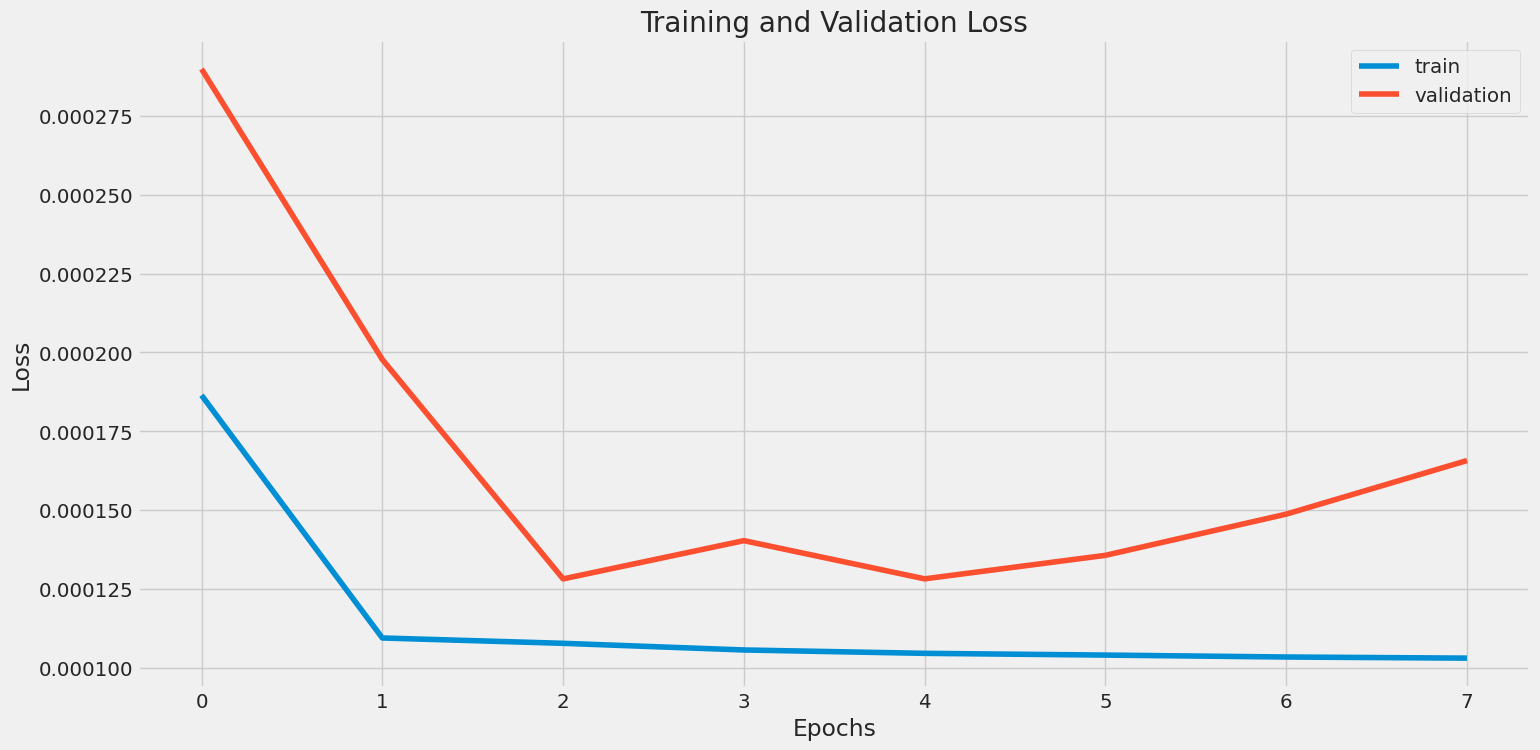

980/980 [==============================] - 4s 3ms/step
RMSE value on validation set: Crime_Incidence    1.759201
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


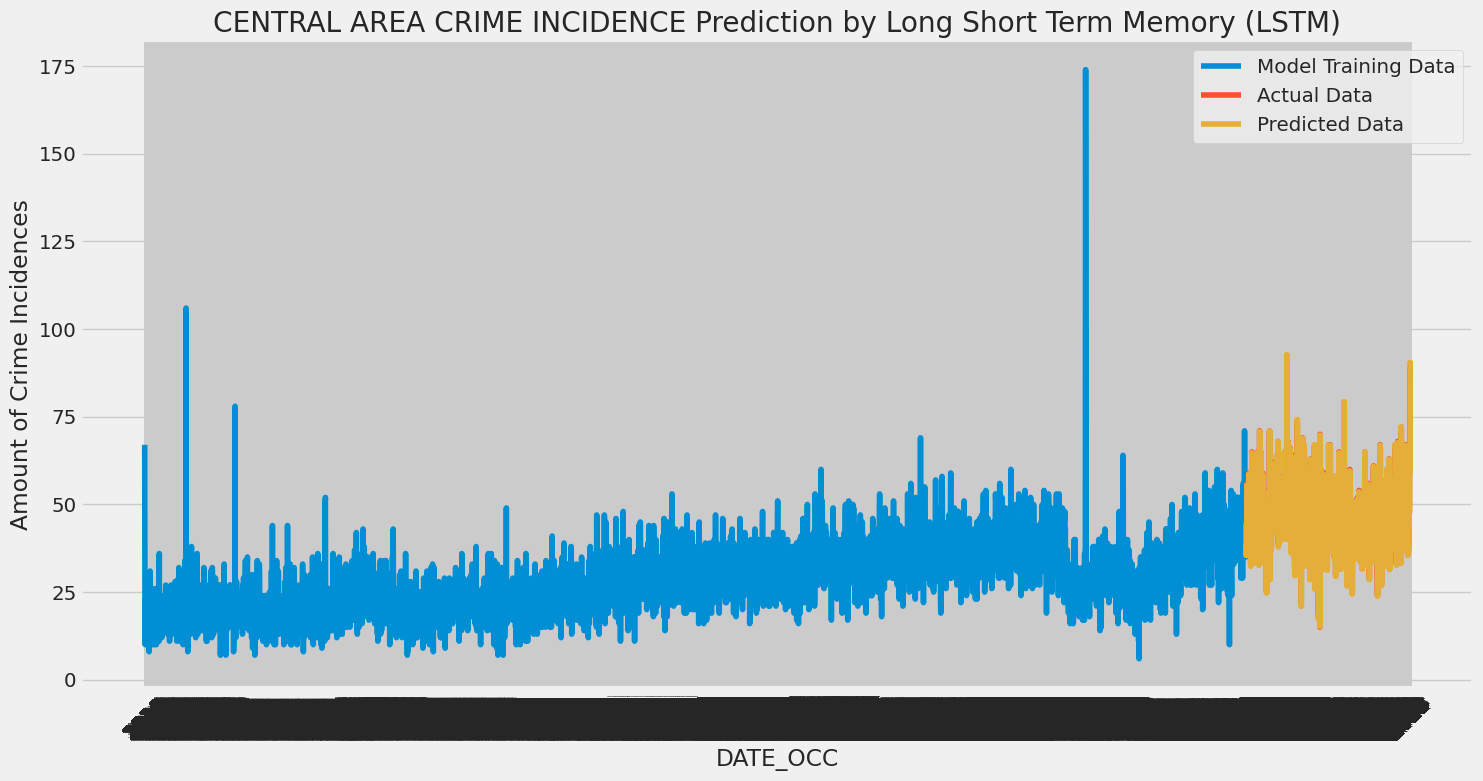

In [ ]:
lstm_prediction(Central_dataset)

**4. LSTM for Pacific Area**